In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#EVALUATE MODEL AND GENERATE GRAPHS

from tensorflow import keras
from keras.layers import Activation
from keras.utils import get_custom_objects
import keras.backend as K
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define the Swish activation function
def swish(x):
    return K.sigmoid(x) * x

# Register the Swish function as a custom activation function
get_custom_objects().update({'swish': Activation(swish),'Activation': Activation})

def evaluate_models(models, test_generators):
    num_models = len(models)

    # Loop through each model and corresponding test generator
    for i in range(num_models):
        model = models[i]
        test_generator = test_generators[i]
        print("model.output_shape[-1]  ",model.output_shape[-1])

        # Generate predictions for the test set
        if model.output_shape[-1] == 1:
          # Binary classification with single neuron in last layer
          if isinstance(model.input, list):
            predictions = model.predict([test_generator[0],test_generator[1]], verbose=1)
          else:
            predictions = model.predict(test_generator, verbose=1)
          y_pred = predictions.ravel() > 0.5
        elif model.output_shape[-1] == 2:
          # Binary classification with two neurons in last layer
          predictions = model.predict(test_generator, verbose=1)
          y_pred = np.argmax(predictions, axis=1)
          y_prob = predictions[:, 1] # Use probabilities for positive class
        else:
          # Multi-class classification
          if isinstance(model.input, list):
            predictions = model.predict(test_generator,test_generator.n // test_generator.batch_size+1, verbose=1)
          else:
            print('hooo')
            #test_steps_per_epoch = numpy.math.ceil(test_batches.samples / test_batches.batch_size)
            predictions = model.predict_generator(test_generator,test_generator.n // test_generator.batch_size+1, verbose=1)
          y_pred = np.argmax(predictions, axis=1)
          y_prob = predictions

        # Convert the one-hot encoded labels to integers
        y_true = test_generator.classes

        # Calculate various metrics
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average='weighted')
        recall = recall_score(y_true, y_pred, average='weighted')
        f1 = f1_score(y_true, y_pred, average='weighted')

        # Print the metrics
        print(f"\n\nModel {i+1} Metrics")
        print('Accuracy: {:.4f}'.format(accuracy))
        print('Precision: {:.4f}'.format(precision))
        print('Recall: {:.4f}'.format(recall))
        print('F1-score: {:.4f}'.format(f1))


        # Get the class indices from the test generator
        class_indices = test_generator.class_indices

        # Invert the class indices to get the class labels with sequence
        class_labels = dict((v, k) for k, v in class_indices.items())

        # Map the integer labels to their corresponding class labels
        y_true_labels = [class_labels[label] for label in y_true]
        y_pred_labels = [class_labels[label] for label in y_pred]


        # Print confusion matrix
        cm = confusion_matrix(y_true_labels, y_pred_labels, labels=list(class_labels.values()))
        print('Confusion matrix:\n', cm)

        # Plot confusion matrix with actual labels
        sns.set(font_scale=1.4)
        plt.figure(figsize=(8, 8))
        sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False, square=True, xticklabels=class_labels.values(), yticklabels=class_labels.values())
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

        #bar graph
        metrics_dict={
            'Accuracy':accuracy,
            'Precision':precision,
            'Recall':recall,
            'F1-Score':f1

        }

        plt.bar(metrics_dict.keys(),metrics_dict.values())
        plt.title('Metrics')
        plt.show()

        if model.output_shape[-1] == 1 or model.output_shape[-1] == 2:
            # Binary classification with one or two neurons in last layer
            tn, fp, fn, tp = cm.ravel()
            fpr, tpr, thresholds = roc_curve(y_true, y_prob)
            roc_auc = auc(fpr, tpr)
            plt.figure(figsize=(8, 6))
            plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('Receiver operating characteristic')
            plt.legend(loc="lower right")
            plt.show()

            # Print ROC curve with class labels
            print("ROC Curve with class labels:")
            for i in range(len(fpr)):
                print("{} {}: {:.2f}".format(y_true_labels[i], class_labels[1], fpr[i]))

        if model.output_shape[-1] != 1 and model.output_shape[-1] != 2:
            # Calculate ROC curve and AUC for multi-class classification
            fpr = dict()
            tpr = dict()
            roc_auc = dict()
            n_classes = model.output_shape[-1]

            for j in range(n_classes):
                fpr[j], tpr[j], _ = roc_curve(y_true == j, y_prob[:, j])
                roc_auc[j] = auc(fpr[j], tpr[j])

            # Plot ROC curve
            sns.set(font_scale=1.4)
            plt.figure(figsize=(8, 8))
            for j in range(n_classes):
                plt.plot(fpr[j], tpr[j], label='ROC curve for {} (area = {:.2f})'.format(class_labels[j], roc_auc[j]), linewidth=2)
            plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('Receiver Operating Characteristic')
            plt.legend(loc="lower right")
            plt.show()

            # Print ROC curve with class labels
            print("ROC Curve with class labels:")
            for j in range(n_classes):
                for i in range(len(fpr[j])):
                    print("{} {}: {:.2f}".format(class_labels[j], y_true_labels[i], fpr[j][i]))




In [ ]:
import numpy as np
import keras
import tensorflow.keras.applications
from keras.callbacks import EarlyStopping ,ModelCheckpoint
from keras.optimizers import SGD

from keras.callbacks import LearningRateScheduler



from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense, Flatten
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import BatchNormalization
from keras.layers.convolutional import *
from sklearn.metrics import confusion_matrix
import itertools
from keras.utils import get_custom_objects

import matplotlib.pyplot as plt
import os
import shutil
import random
import glob
import math
import tensorflow as tf
%matplotlib inline


In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives +
    K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)

    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
train_path = '/content/drive/MyDrive/TeaDataSet/train'
valid_path = '/content/drive/MyDrive/TeaDataSet/valid'
test_path = '/content/drive/MyDrive/TeaDataSet/test'


get_custom_objects().update({'f1_m': f1_m,'precision_m':precision_m, 'recall_m':recall_m})



In [ ]:
rootdir = '/content/drive/MyDrive/teaSicknessDataset/'
dirList=[]

for it in os.scandir(rootdir):
    if it.is_dir():
      dirList.append(it.name)
print(dirList)

for dir in dirList:
  os.chdir(rootdir)
  os.chdir(dir)
  count=1
  for file in os.listdir(rootdir+dir):
    dst=dir.replace(" ","")+'_'+str(count)+'.jpg'
    count=count+1
    os.rename(file,dst)



['algal leaf', 'healthy', 'red leaf spot', 'gray light', 'brown blight', 'bird eye spot', 'Anthracnose', 'white spot']


In [ ]:
os. getcwd()
os.chdir('/content/drive/MyDrive/')

if os.path.isdir('/content/drive/MyDrive/TeaDataSet') is False:
  os.makedirs('/content/drive/MyDrive/TeaDataSet')
  os.makedirs('/content/drive/MyDrive/TeaDataSet/train/Anthracnose')
  os.makedirs('/content/drive/MyDrive/TeaDataSet/valid/Anthracnose')
  os.makedirs('/content/drive/MyDrive/TeaDataSet/test/Anthracnose')

  os.makedirs('/content/drive/MyDrive/TeaDataSet/train/algal leaf')
  os.makedirs('/content/drive/MyDrive/TeaDataSet/valid/algal leaf')
  os.makedirs('/content/drive/MyDrive/TeaDataSet/test/algal leaf')

  os.makedirs('/content/drive/MyDrive/TeaDataSet/train/bird eye spot')
  os.makedirs('/content/drive/MyDrive/TeaDataSet/valid/bird eye spot')
  os.makedirs('/content/drive/MyDrive/TeaDataSet/test/bird eye spot')

  os.makedirs('/content/drive/MyDrive/TeaDataSet/train/brown blight')
  os.makedirs('/content/drive/MyDrive/TeaDataSet/valid/brown blight')
  os.makedirs('/content/drive/MyDrive/TeaDataSet/test/brown blight')


  os.makedirs('/content/drive/MyDrive/TeaDataSet/train/gray light')
  os.makedirs('/content/drive/MyDrive/TeaDataSet/valid/gray light')
  os.makedirs('/content/drive/MyDrive/TeaDataSet/test/gray light')

  os.makedirs('/content/drive/MyDrive/TeaDataSet/train/healthy')
  os.makedirs('/content/drive/MyDrive/TeaDataSet/valid/healthy')
  os.makedirs('/content/drive/MyDrive/TeaDataSet/test/healthy')

  os.makedirs('/content/drive/MyDrive/TeaDataSet/train/red leaf spot')
  os.makedirs('/content/drive/MyDrive/TeaDataSet/valid/red leaf spot')
  os.makedirs('/content/drive/MyDrive/TeaDataSet/test/red leaf spot')

  os.makedirs('/content/drive/MyDrive/TeaDataSet/train/white spot')
  os.makedirs('/content/drive/MyDrive/TeaDataSet/valid/white spot')
  os.makedirs('/content/drive/MyDrive/TeaDataSet/test/white spot')
  os.chdir('/content/drive/MyDrive/')

#for s in random.sample(glob.glob('*'),)
classes=['Anthracnose','white spot','red leaf spot','healthy','gray light','brown blight','bird eye spot','algal leaf']
path="/content/drive/MyDrive/teaSicknessDataset/";
pathNew='/content/drive/MyDrive/TeaDataSet/';
for cls in classes:
  #print(len(os.listdir(path+cls)))
  totalRecords=len(os.listdir(path+cls))
  print("className: "+cls)
  print("Total records : "+str(totalRecords))
  trainPercentage= 0.8
  testPercentage=0.1
  validPercentage=0.1
  #print(math.ceil(trainPercentage*len(os.listdir(path+cls))))
  print("Train: "+str(len(random.sample(os.listdir(path+cls),math.floor(trainPercentage*totalRecords)))));
  for s in random.sample(os.listdir(path+cls),math.floor(trainPercentage*totalRecords)):
    shutil.move(path+cls+'/'+s,pathNew+'train/'+cls+'/')
    #print(s)

  print("Test: "+str(len(random.sample(os.listdir(path+cls),math.floor(testPercentage*totalRecords)))));
  for s in random.sample(os.listdir(path+cls),math.floor(testPercentage*totalRecords)):
    shutil.move(path+cls+'/'+s,pathNew+'test/'+cls+'/')
    #print(s)

  print("Valid: "+str(len(random.sample(os.listdir(path+cls),math.floor(validPercentage*totalRecords)))));
  for s in random.sample(os.listdir(path+cls),math.floor(validPercentage*totalRecords)):
    shutil.move(path+cls+'/'+s,pathNew+'valid/'+cls+'/')
    #print(s)

className: Anthracnose
Total records : 100
L1: 80
L2: 10
L3: 10
className: white spot
Total records : 142
L1: 113
L2: 14
L3: 14
className: red leaf spot
Total records : 143
L1: 114
L2: 14
L3: 14
className: healthy
Total records : 74
L1: 59
L2: 7
L3: 7
className: gray light
Total records : 100
L1: 80
L2: 10
L3: 10
className: brown blight
Total records : 113
L1: 90
L2: 11
L3: 11
className: bird eye spot
Total records : 100
L1: 80
L2: 10
L3: 10
className: algal leaf
Total records : 113
L1: 90
L2: 11
L3: 11


In [ ]:
shutil.rmtree('/content/drive/MyDrive/TeaDataSet', ignore_errors=True)
shutil.rmtree('/content/drive/MyDrive/teaSicknessDataset/', ignore_errors=True)



In [ ]:
train_batches = ImageDataGenerator( rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest',preprocessing_function=tf.keras.applications.vgg16.preprocess_input
).flow_from_directory(train_path, target_size=(224,224), batch_size=10)
valid_batches = ImageDataGenerator(rescale=1./255,preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(valid_path, target_size=(224,224), batch_size=10)
test_batches = ImageDataGenerator(rescale=1./255,preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(test_path, target_size=(224,224), batch_size=10,shuffle=False)


Found 706 images belonging to 8 classes.
Found 87 images belonging to 8 classes.
Found 87 images belonging to 8 classes.


In [ ]:
def plotImages(images_arr):
  fig, axes = plt.subplots(1, 10, figsize=(40,40))
  axes = axes.flatten()
  for img, ax in zip( images_arr, axes):
    ax.imshow( img)
    ax.axis('off')
  plt.tight_layout()
  plt.show()

In [ ]:
imgs, labels = next(train_batches)
print(labels)

[[0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]


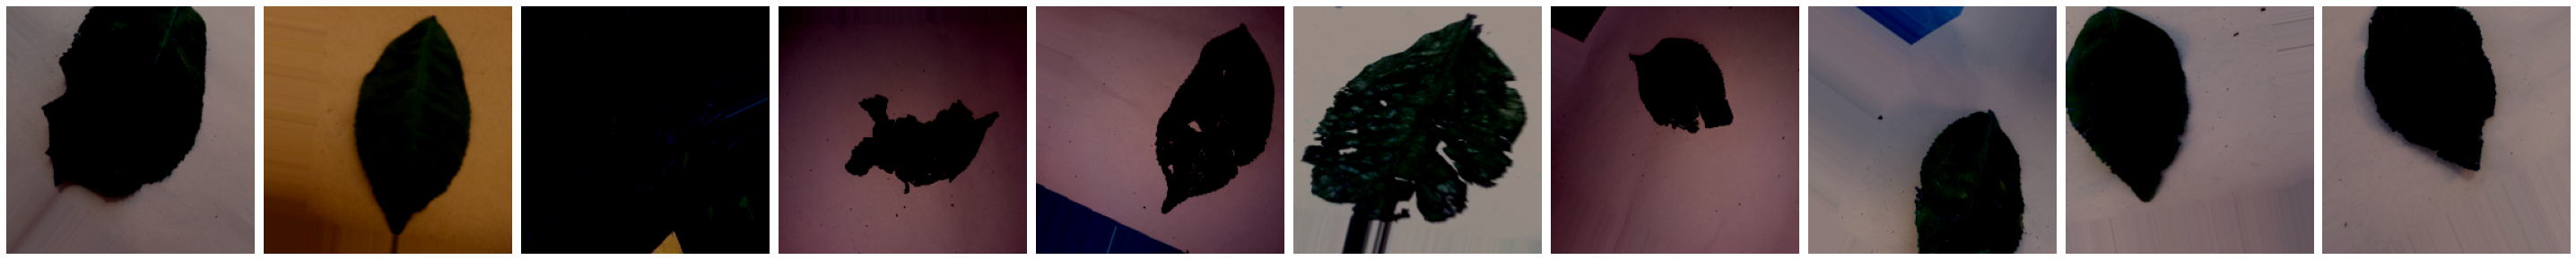

In [ ]:
plotImages(imgs)

In [ ]:
train_batches.class_indices

{'Anthracnose': 0,
 'algal leaf': 1,
 'bird eye spot': 2,
 'brown blight': 3,
 'gray light': 4,
 'healthy': 5,
 'red leaf spot': 6,
 'white spot': 7}

In [ ]:
vgg16_model = keras.applications.vgg16.VGG16()


553467096/553467096 [==============================] - 17s 0us/step


In [ ]:
vgg16_model.summary()


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
model = Sequential()
for layer in vgg16_model.layers[:-1]:
    model.add(layer)
    layer.trainable = False

model.add(Dense(8, activation='softmax'))



callback_list=[EarlyStopping(monitor="val_loss",patience=100),ModelCheckpoint(filepath="/content/drive/MyDrive/vgg16TeaLeaf.h5",monitor="val_loss",save_best_only=True,verbose=1)]


model.compile(Adam(lr=.99), loss='categorical_crossentropy', metrics=['accuracy',recall_m,precision_m,f1_m])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

In [ ]:

history=model.fit_generator(train_batches,callbacks=callback_list,
                    validation_data=valid_batches, epochs=100, verbose=2)
if os.path.isfile('/content/drive/MyDrive/model.h5') is False:attachment
  model.save('/content/drive/MyDrive/model.h5')


<ipython-input-17-ddb45a69058f>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train_batches,callbacks=callback_list,


Epoch 1/100

Epoch 1: val_loss improved from inf to 261.90359, saving model to /content/drive/MyDrive/vgg16TeaLeaf.h5
71/71 - 319s - loss: 1295.3756 - accuracy: 0.1785 - recall_m: 0.1746 - precision_m: 0.1746 - f1_m: 0.1746 - val_loss: 261.9036 - val_accuracy: 0.4253 - val_recall_m: 0.4159 - val_precision_m: 0.4159 - val_f1_m: 0.4159 - 319s/epoch - 4s/step
Epoch 2/100

Epoch 2: val_loss did not improve from 261.90359
71/71 - 76s - loss: 357.3308 - accuracy: 0.3258 - recall_m: 0.3239 - precision_m: 0.3239 - f1_m: 0.3239 - val_loss: 300.9175 - val_accuracy: 0.3448 - val_recall_m: 0.3381 - val_precision_m: 0.3381 - val_f1_m: 0.3381 - 76s/epoch - 1s/step
Epoch 3/100

Epoch 3: val_loss did not improve from 261.90359
71/71 - 74s - loss: 336.8126 - accuracy: 0.3739 - recall_m: 0.3737 - precision_m: 0.3737 - f1_m: 0.3737 - val_loss: 729.8867 - val_accuracy: 0.2759 - val_recall_m: 0.2714 - val_precision_m: 0.2714 - val_f1_m: 0.2714 - 74s/epoch - 1s/step
Epoch 4/100

Epoch 4: val_loss did not im

KeyboardInterrupt: ignored

In [ ]:
#LOAD AND RETRAIN VGG16 MODEL
from keras.layers import Activation
from keras.utils import get_custom_objects
import keras.backend as K
from keras.models import load_model


# Load the saved model with custom activation function
model = load_model('/content/drive/MyDrive/vgg16TeaLeaf.h5')

model.summary()

callback_list=[EarlyStopping(monitor="val_loss",patience=100),ModelCheckpoint(filepath="/content/drive/MyDrive/vgg16TeaLeaf.h5",monitor="val_loss",save_best_only=True,verbose=1)]


model.compile(Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy',recall_m,precision_m,f1_m])

history=model.fit_generator(train_batches,callbacks=callback_list,validation_data=valid_batches, epochs=100, verbose=2)



OSError: ignored

In [ ]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

NameError: ignored

Found 87 images belonging to 8 classes.
model.output_shape[-1]   8
hooo


<ipython-input-13-add47645ee33>:49: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(test_generator,test_generator.n // test_generator.batch_size+1, verbose=1)


9/9 [==============================] - 8s 619ms/step


Model 1 Metrics
Accuracy: 0.7586
Precision: 0.7917
Recall: 0.7586
F1-score: 0.7591
Confusion matrix:
 [[10  0  0  0  0  0  0  0]
 [ 1  9  0  0  0  1  0  0]
 [ 3  1  5  0  1  0  0  0]
 [ 0  1  0  9  0  0  0  1]
 [ 0  1  3  0  6  0  0  0]
 [ 0  0  0  1  0  6  0  0]
 [ 1  3  0  0  0  0  9  1]
 [ 0  1  1  0  0  0  0 12]]


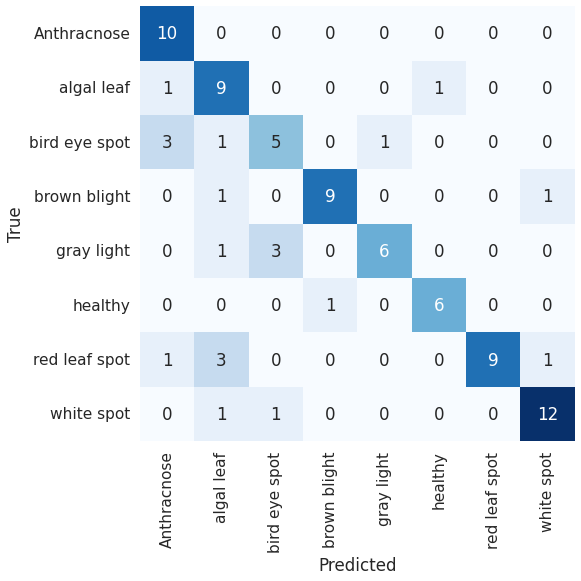

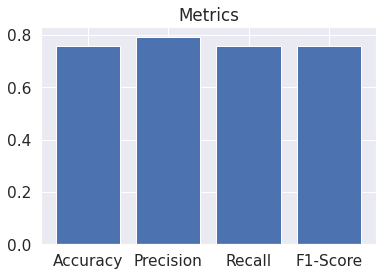

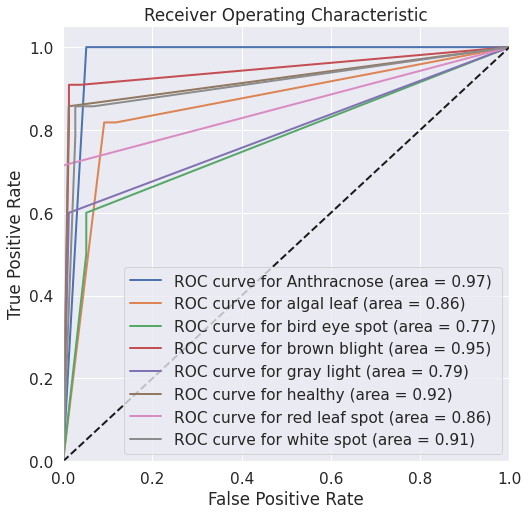

ROC Curve with class labels:
Anthracnose Anthracnose: 0.00
Anthracnose Anthracnose: 0.05
Anthracnose Anthracnose: 0.09
Anthracnose Anthracnose: 1.00
algal leaf Anthracnose: 0.00
algal leaf Anthracnose: 0.09
algal leaf Anthracnose: 0.12
algal leaf Anthracnose: 1.00
bird eye spot Anthracnose: 0.00
bird eye spot Anthracnose: 0.05
bird eye spot Anthracnose: 0.05
bird eye spot Anthracnose: 1.00
brown blight Anthracnose: 0.00
brown blight Anthracnose: 0.01
brown blight Anthracnose: 0.01
brown blight Anthracnose: 0.04
brown blight Anthracnose: 1.00
gray light Anthracnose: 0.00
gray light Anthracnose: 0.01
gray light Anthracnose: 1.00
healthy Anthracnose: 0.00
healthy Anthracnose: 0.01
healthy Anthracnose: 1.00
red leaf spot Anthracnose: 0.00
red leaf spot Anthracnose: 0.00
red leaf spot Anthracnose: 0.00
red leaf spot Anthracnose: 1.00
white spot Anthracnose: 0.00
white spot Anthracnose: 0.03
white spot Anthracnose: 0.03
white spot Anthracnose: 0.07
white spot Anthracnose: 1.00


In [ ]:
# EVALUATE PERFORMANCE OF VGG15TEALEAF MODEL

from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator

get_custom_objects().update({'f1_m': f1_m,'precision_m':precision_m, 'recall_m':recall_m})

# Load trained model
model = load_model('/content/drive/MyDrive/vgg16TeaLeaf.h5')

#model.summary()
# Define test generator with data augmentation
test_batches = ImageDataGenerator(rescale=1./255,preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(test_path, target_size=(224,224), batch_size=10,shuffle=False)


evaluate_models([model],[test_batches])


/usr/local/lib/python3.9/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


model.output_shape[-1]   (None, 8)
hooo


<ipython-input-12-83ecae13a7a7>:49: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(test_generator,test_generator.n // test_generator.batch_size+1, verbose=1)[0]


9/9 [==============================] - 8s 615ms/step


Model 1 Metrics
Accuracy: 0.8276
Precision: 0.8581
Recall: 0.8276
F1-score: 0.8271
Confusion matrix:
 [[ 5  0  4  0  1  0  0  0]
 [ 0 11  0  0  0  0  0  0]
 [ 0  0  8  0  2  0  0  0]
 [ 0  1  0 10  0  0  0  0]
 [ 0  0  2  0  8  0  0  0]
 [ 0  0  0  0  0  7  0  0]
 [ 0  0  0  0  0  0 13  1]
 [ 0  0  0  4  0  0  0 10]]


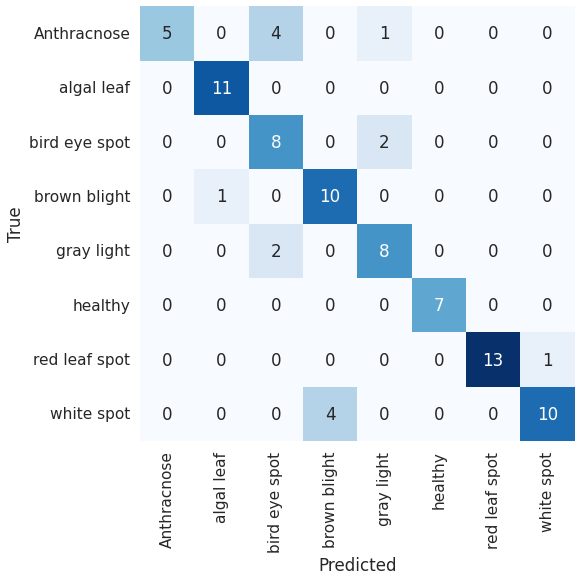

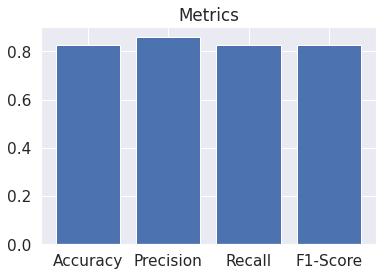

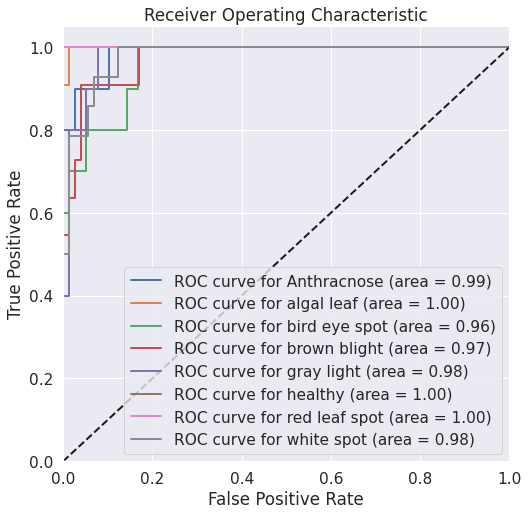

ROC Curve with class labels:
Anthracnose Anthracnose: 0.00
Anthracnose Anthracnose: 0.00
Anthracnose Anthracnose: 0.00
Anthracnose Anthracnose: 0.03
Anthracnose Anthracnose: 0.03
Anthracnose Anthracnose: 0.10
Anthracnose Anthracnose: 0.10
Anthracnose Anthracnose: 1.00
algal leaf Anthracnose: 0.00
algal leaf Anthracnose: 0.00
algal leaf Anthracnose: 0.00
algal leaf Anthracnose: 0.01
algal leaf Anthracnose: 0.01
algal leaf Anthracnose: 1.00
bird eye spot Anthracnose: 0.00
bird eye spot Anthracnose: 0.00
bird eye spot Anthracnose: 0.00
bird eye spot Anthracnose: 0.01
bird eye spot Anthracnose: 0.01
bird eye spot Anthracnose: 0.05
bird eye spot Anthracnose: 0.05
bird eye spot Anthracnose: 0.14
bird eye spot Anthracnose: 0.14
bird eye spot Anthracnose: 0.17
bird eye spot algal leaf: 0.17
bird eye spot algal leaf: 1.00
brown blight Anthracnose: 0.00
brown blight Anthracnose: 0.00
brown blight Anthracnose: 0.00
brown blight Anthracnose: 0.01
brown blight Anthracnose: 0.01
brown blight Anthrac

In [ ]:
#LOAD AND EVALUATE GOOGLE NET MODEL

import numpy
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
import sklearn.metrics as metrics
from keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix

get_custom_objects().update({'f1_m': f1_m,'precision_m':precision_m, 'recall_m':recall_m})

# Load trained model
model = load_model('/content/drive/MyDrive/googlenetmodel9mar2023.h5')

evaluate_googlenet_models([model], [test_batches])


model.output_shape[-1]   8
hooo


<ipython-input-2-add47645ee33>:49: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(test_generator,test_generator.n // test_generator.batch_size+1, verbose=1)


9/9 [==============================] - 28s 3s/step


Model 1 Metrics
Accuracy: 0.7931
Precision: 0.8076
Recall: 0.7931
F1-score: 0.7886
Confusion matrix:
 [[ 4  0  2  0  4  0  0  0]
 [ 0 11  0  0  0  0  0  0]
 [ 1  0  4  0  5  0  0  0]
 [ 0  0  0 10  0  0  0  1]
 [ 1  0  1  0  8  0  0  0]
 [ 0  0  0  0  0  6  1  0]
 [ 0  0  0  0  0  0 14  0]
 [ 0  0  0  1  0  0  1 12]]


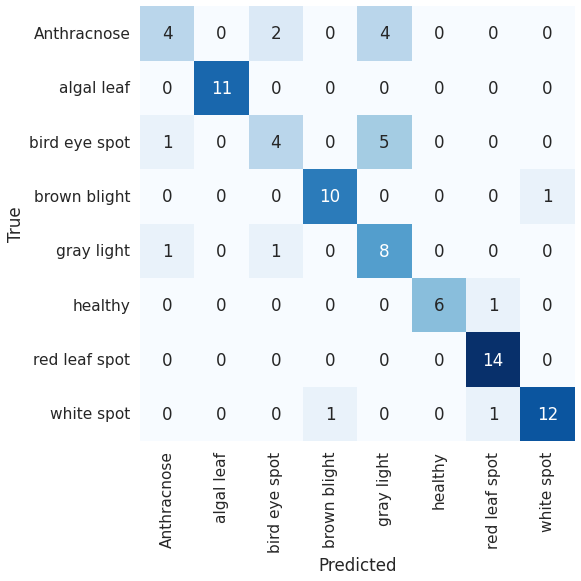

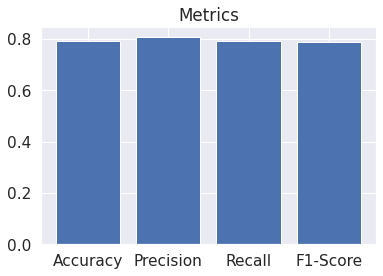

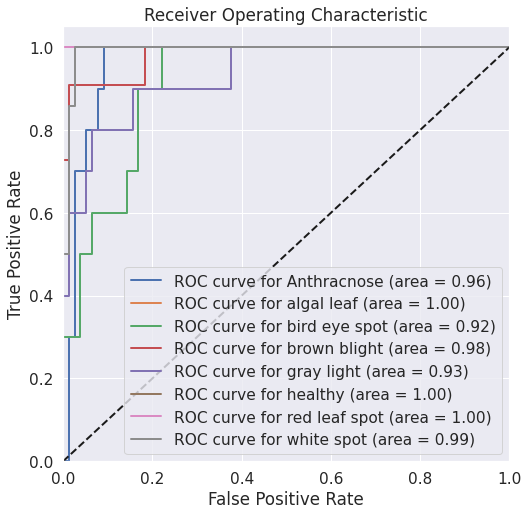

In [ ]:
#EVALUATE PERFORMANCE OF RESNET50 TEST DATA

import numpy
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
import sklearn.metrics as metrics
from keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix

get_custom_objects().update({'f1_m': f1_m,'precision_m':precision_m, 'recall_m':recall_m})

# Load trained model
model = load_model('/content/drive/MyDrive/resnet5013Mar.h5')

evaluate_models([model], [test_batches])

In [ ]:
#EVALUATE GOOGLENET MODEL AND GENERATE GRAPHS

from tensorflow import keras
from keras.layers import Activation
from keras.utils import get_custom_objects
import keras.backend as K
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define the Swish activation function
def swish(x):
    return K.sigmoid(x) * x

# Register the Swish function as a custom activation function
get_custom_objects().update({'swish': Activation(swish),'Activation': Activation})

def evaluate_googlenet_models(models, test_generators):
    num_models = len(models)

    # Loop through each model and corresponding test generator
    for i in range(num_models):
        model = models[i]
        test_generator = test_generators[i]
        print("model.output_shape[-1]  ",model.output_shape[-1])

        # Generate predictions for the test set
        if model.output_shape[-1] == 1:
          # Binary classification with single neuron in last layer
          if isinstance(model.input, list):
            predictions = model.predict([test_generator[0],test_generator[1]], verbose=1)
          else:
            predictions = model.predict(test_generator, verbose=1)
          y_pred = predictions.ravel() > 0.5
        elif model.output_shape[-1] == 2:
          # Binary classification with two neurons in last layer
          predictions = model.predict(test_generator, verbose=1)
          y_pred = np.argmax(predictions, axis=1)
          y_prob = predictions[:, 1] # Use probabilities for positive class
        else:
          # Multi-class classification
          if isinstance(model.input, list):
            predictions = model.predict(test_generator,test_generator.n // test_generator.batch_size+1, verbose=1)
          else:
            print('hooo')
            #test_steps_per_epoch = numpy.math.ceil(test_batches.samples / test_batches.batch_size)
            predictions = model.predict_generator(test_generator,test_generator.n // test_generator.batch_size+1, verbose=1)[0]
          y_pred = np.argmax(predictions, axis=1)
          y_prob = predictions

        # Convert the one-hot encoded labels to integers
        y_true = test_generator.classes

        # Calculate various metrics
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average='weighted')
        recall = recall_score(y_true, y_pred, average='weighted')
        f1 = f1_score(y_true, y_pred, average='weighted')

        # Print the metrics
        print(f"\n\nModel {i+1} Metrics")
        print('Accuracy: {:.4f}'.format(accuracy))
        print('Precision: {:.4f}'.format(precision))
        print('Recall: {:.4f}'.format(recall))
        print('F1-score: {:.4f}'.format(f1))


        # Get the class indices from the test generator
        class_indices = test_generator.class_indices

        # Invert the class indices to get the class labels with sequence
        class_labels = dict((v, k) for k, v in class_indices.items())

        # Map the integer labels to their corresponding class labels
        y_true_labels = [class_labels[label] for label in y_true]
        y_pred_labels = [class_labels[label] for label in y_pred]


        # Print confusion matrix
        cm = confusion_matrix(y_true_labels, y_pred_labels, labels=list(class_labels.values()))
        print('Confusion matrix:\n', cm)

        # Plot confusion matrix with actual labels
        sns.set(font_scale=1.4)
        plt.figure(figsize=(8, 8))
        sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False, square=True, xticklabels=class_labels.values(), yticklabels=class_labels.values())
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

        #bar graph
        metrics_dict={
            'Accuracy':accuracy,
            'Precision':precision,
            'Recall':recall,
            'F1-Score':f1

        }

        plt.bar(metrics_dict.keys(),metrics_dict.values())
        plt.title('Metrics')
        plt.show()

        if model.output_shape[-1] == 1 or model.output_shape[-1] == 2:
            # Binary classification with one or two neurons in last layer
            tn, fp, fn, tp = cm.ravel()
            fpr, tpr, thresholds = roc_curve(y_true, y_prob)
            roc_auc = auc(fpr, tpr)
            plt.figure(figsize=(8, 6))
            plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('Receiver operating characteristic')
            plt.legend(loc="lower right")
            plt.show()

            # Print ROC curve with class labels
            print("ROC Curve with class labels:")
            for i in range(len(fpr)):
                print("{} {}: {:.2f}".format(y_true_labels[i], class_labels[1], fpr[i]))

        if model.output_shape[-1] != 1 and model.output_shape[-1] != 2:
            # Calculate ROC curve and AUC for multi-class classification
            fpr = dict()
            tpr = dict()
            roc_auc = dict()
            n_classes = model.output_shape[-1][1]

            for j in range(n_classes):
                fpr[j], tpr[j], _ = roc_curve(y_true == j, y_prob[:, j])
                roc_auc[j] = auc(fpr[j], tpr[j])

            # Plot ROC curve
            sns.set(font_scale=1.4)
            plt.figure(figsize=(8, 8))
            for j in range(n_classes):
                plt.plot(fpr[j], tpr[j], label='ROC curve for {} (area = {:.2f})'.format(class_labels[j], roc_auc[j]), linewidth=2)
            plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('Receiver Operating Characteristic')
            plt.legend(loc="lower right")
            plt.show()

            # Print ROC curve with class labels
            print("ROC Curve with class labels:")
            for j in range(n_classes):
                for i in range(len(fpr[j])):
                    print("{} {}: {:.2f}".format(class_labels[j], y_true_labels[i], fpr[j][i]))




In [ ]:
inception_v3_model = keras.applications.inception_v3.InceptionV3()
inception_v3_model.summary()

96112376/96112376 [==============================] - 1s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)           

In [ ]:
train_batches = ImageDataGenerator( rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest',preprocessing_function=tf.keras.applications.inception_v3.preprocess_input
).flow_from_directory(train_path, target_size=(224,224), batch_size=10)
valid_batches = ImageDataGenerator(rescale=1./255,preprocessing_function=tf.keras.applications.inception_v3.preprocess_input).flow_from_directory(valid_path, target_size=(224,224), batch_size=10)
test_batches = ImageDataGenerator(rescale=1./255,preprocessing_function=tf.keras.applications.inception_v3.preprocess_input).flow_from_directory(test_path, target_size=(224,224), batch_size=10,shuffle=False)


Found 706 images belonging to 8 classes.
Found 87 images belonging to 8 classes.
Found 87 images belonging to 8 classes.


In [ ]:
#google net

import cv2
import numpy as np
import keras
import tensorflow as tf
from keras.datasets import cifar10 # importing the dataset
from keras import backend as K
from keras.utils import np_utils
from keras.layers import Layer
import keras.backend as K
import math
from keras.optimizers import SGD
from keras.callbacks import LearningRateScheduler
from keras.datasets import cifar10
from keras.models import Model
from keras.layers import Conv2D, MaxPool2D,Dropout, Dense, Input, concatenate,GlobalAveragePooling2D, AveragePooling2D,Flatten

In [ ]:
def inception_module(x,filters_1x1,filters_3x3_reduce,filters_3x3,filters_5x5_reduce,filters_5x5,filters_pool_proj,name=None):
  conv_1x1 = Conv2D(filters_1x1, (1, 1), padding="same", activation="relu", kernel_initializer=kernel_init, bias_initializer=bias_init)(x)

  conv_3x3 = Conv2D(filters_3x3_reduce, (1, 1), padding="same", activation="relu", kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
  conv_3x3 = Conv2D(filters_3x3, (3, 3), padding="same", activation="relu", kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_3x3)
  conv_5x5 = Conv2D(filters_5x5_reduce, (1, 1), padding="same", activation="relu", kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
  conv_5x5 = Conv2D(filters_5x5, (5, 5), padding="same", activation="relu", kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_5x5)
  pool_proj = MaxPool2D((3, 3), strides=(1, 1), padding="same")(x)
  pool_proj = Conv2D(filters_pool_proj, (1, 1), padding="same", activation="relu", kernel_initializer=kernel_init, bias_initializer=bias_init)(pool_proj)
  output = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=3, name=name)
  return output
kernel_init = keras.initializers.glorot_uniform()
bias_init = keras.initializers.Constant(value=0.2)

In [ ]:
input_layer = Input(shape=(224, 224, 3),name='googlenetInput')
x = Conv2D(64, (7, 7), padding="same", strides=(2, 2), activation="relu", name="conv_1_7x7/2", kernel_initializer=kernel_init, bias_initializer=bias_init)(input_layer)
x = MaxPool2D((3, 3), padding="same", strides=(2, 2), name="max_pool_1_3x3/2")(x)
x = Conv2D(64, (1, 1), padding="same", strides=(1, 1), activation="relu", name="conv_2a_3x3/1")(x)
x = Conv2D(192, (3, 3), padding="same", strides=(1, 1), activation="relu", name="conv_2b_3x3/1")(x)
x = MaxPool2D((3, 3), padding="same", strides=(2, 2), name="max_pool_2_3x3/2")(x)
x = inception_module(x,filters_1x1=64,filters_3x3_reduce=96,
 filters_3x3=128,filters_5x5_reduce=16,
 filters_5x5=32,filters_pool_proj=32,
 name="inception_3a")
x = inception_module(x,filters_1x1=128,filters_3x3_reduce=128,
 filters_3x3=192,filters_5x5_reduce=32,
 filters_5x5=96,filters_pool_proj=64,
 name="inception_3b")
x = MaxPool2D((3, 3), padding="same", strides=(2, 2), name="max_pool_3_3x3/2")(x)
x = inception_module(x,filters_1x1=192,filters_3x3_reduce=96,
filters_3x3=208,filters_5x5_reduce=16,filters_5x5=48,filters_pool_proj=64,
 name="inception_4a")
x1 = AveragePooling2D((5, 5), strides=3)(x)
x1 = Conv2D(128, (1, 1), padding="same", activation="relu")(x1)
x1 = Flatten()(x1)
x1 = Dense(1024, activation="relu")(x1)
x1 = Dropout(0.7)(x1)
x1 = Dense(8, activation="softmax", name="auxilliary_output_1")(x1)
x = inception_module(x,filters_1x1=160,filters_3x3_reduce=112,filters_3x3=224,filters_5x5_reduce=24,filters_5x5=64,filters_pool_proj=64,name="inception_4b")
x = inception_module(x,filters_1x1=128,filters_3x3_reduce=128,
 filters_3x3=256,filters_5x5_reduce=24,filters_5x5=64,
 filters_pool_proj=64,name="inception_4c")
x = inception_module(x,filters_1x1=112,filters_3x3_reduce=144,
 filters_3x3=288,filters_5x5_reduce=32,filters_5x5=64,
 filters_pool_proj=64,
 name="inception_4d")
x2 = AveragePooling2D((5, 5), strides=3)(x)
x2 = Conv2D(128, (1, 1), padding="same", activation="relu")(x2)
x2 = Flatten()(x2)
x2 = Dense(1024, activation="relu")(x2)
x2 = Dropout(0.7)(x2)
x2 = Dense(8, activation="softmax", name="auxilliary_output_2")(x2)
x = inception_module(x,filters_1x1=256,filters_3x3_reduce=160,
 filters_3x3=320,filters_5x5_reduce=32,filters_5x5=128,
 filters_pool_proj=128,
 name="inception_4e")
x = MaxPool2D((3, 3), padding="same", strides=(2, 2), name="max_pool_4_3x3/2")(x)
x = inception_module(x,filters_1x1=256,filters_3x3_reduce=160,
 filters_3x3=320,filters_5x5_reduce=32,filters_5x5=128,
 filters_pool_proj=128,
 name="inception_5a")
x = inception_module(x, filters_1x1=384,filters_3x3_reduce=192,
 filters_3x3=384,filters_5x5_reduce=48,filters_5x5=128,
 filters_pool_proj=128,
 name="inception_5b")
x = GlobalAveragePooling2D(name="avg_pool_5_3x3/1")(x)
x = Dropout(0.4)(x)
x = Dense(8, activation="softmax", name="output")(x)
model = Model(input_layer, [x,x1,x2] , name="inception_v1")

/usr/local/lib/python3.9/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [ ]:
model.summary()

Model: "inception_v1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 googlenetInput (InputLayer)    [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv_1_7x7/2 (Conv2D)          (None, 112, 112, 64  9472        ['googlenetInput[0][0]']         
                                )                                                                 
                                                                                                  
 max_pool_1_3x3/2 (MaxPooling2D  (None, 56, 56, 64)  0           ['conv_1_7x7/2[0][0]']           
 )                                                                                     

In [ ]:
epochs = 100
initial_lrate = 0.001
def decay(epoch, steps=100):
  initial_lrate = 0.01
  drop = 0.96
  epochs_drop = 8
  lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
  return lrate
sgd = SGD(lr=initial_lrate, momentum=0.9, nesterov=False)
lr_sc = LearningRateScheduler(decay, verbose=1)

callback_list=[EarlyStopping(monitor="val_loss",patience=100),ModelCheckpoint(filepath="/content/drive/MyDrive/googlenetmodelmar2023.h5",monitor="val_loss",save_best_only=True,verbose=1)]


model.compile(loss=["categorical_crossentropy", "categorical_crossentropy", "categorical_crossentropy"], loss_weights=[1, 0.3, 0.3], optimizer=sgd, metrics=['accuracy',recall_m,precision_m,f1_m])

In [ ]:
#model.compile(Adam(lr=0.00000000000000000000000001),loss="categorical_crossentropy",metrics=['accuracy'])


history=model.fit_generator(train_batches,validation_data=valid_batches,callbacks=callback_list, epochs=1000, verbose=1)



<ipython-input-15-b08cbc996b76>:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train_batches,validation_data=valid_batches,callbacks=callback_list, epochs=1000, verbose=1)


Epoch 1/1000
71/71 [==============================] - ETA: 0s - loss: 3.5241 - output_loss: 2.2417 - auxilliary_output_1_loss: 2.1323 - auxilliary_output_2_loss: 2.1426 - output_accuracy: 0.1360 - output_recall_m: 0.0000e+00 - output_precision_m: 0.0000e+00 - output_f1_m: 0.0000e+00 - auxilliary_output_1_accuracy: 0.1388 - auxilliary_output_1_recall_m: 0.0000e+00 - auxilliary_output_1_precision_m: 0.0000e+00 - auxilliary_output_1_f1_m: 0.0000e+00 - auxilliary_output_2_accuracy: 0.1317 - auxilliary_output_2_recall_m: 0.0000e+00 - auxilliary_output_2_precision_m: 0.0000e+00 - auxilliary_output_2_f1_m: 0.0000e+00
Epoch 1: val_loss improved from inf to 3.35990, saving model to /content/drive/MyDrive/googlenetmodel12mar2023.h5
71/71 [==============================] - 271s 4s/step - loss: 3.5241 - output_loss: 2.2417 - auxilliary_output_1_loss: 2.1323 - auxilliary_output_2_loss: 2.1426 - output_accuracy: 0.1360 - output_recall_m: 0.0000e+00 - output_precision_m: 0.0000e+00 - output_f1_m: 0.0

KeyboardInterrupt: ignored

In [ ]:
#LOAD AND RETRAIN googlenet MODEL
from keras.layers import Activation
from keras.utils import get_custom_objects
import keras.backend as K
from keras.models import load_model

epochs = 15
initial_lrate = 0.0001
def decay(epoch, steps=100):
  initial_lrate = 0.01
  drop = 0.96
  epochs_drop = 8
  lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
  return lrate
sgd = SGD(lr=initial_lrate, momentum=0.9, nesterov=False)
lr_sc = LearningRateScheduler(decay, verbose=1)


# Load the saved model with custom activation function
googlenetModel = load_model('/content/drive/MyDrive/googlenetmodel.h5')

googlenetModel.compile(loss=["categorical_crossentropy", "categorical_crossentropy", "categorical_crossentropy"], loss_weights=[1, 0.3, 0.3], optimizer=sgd, metrics=['accuracy',recall_m,precision_m,f1_m])


googlenetModel.summary()

callback_list=[EarlyStopping(monitor="val_loss",patience=100),ModelCheckpoint(filepath="/content/drive/MyDrive/googlenetmodel.h5",monitor="val_loss",save_best_only=True,verbose=1)]



history=googlenetModel.fit_generator(train_batches,callbacks=callback_list,validation_data=valid_batches, epochs=100, verbose=2)



/usr/local/lib/python3.8/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


KeyboardInterrupt: ignored

In [ ]:
#LOAD AND EVALUATE GOOGLE NET MODEL

import numpy
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
import sklearn.metrics as metrics
from keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix

get_custom_objects().update({'f1_m': f1_m,'precision_m':precision_m, 'recall_m':recall_m})

# Load trained model
model = load_model('/content/drive/MyDrive/googlenetmodel9mar2023.h5')


# Get the class indices from the test generator
class_indices = test_batches.class_indices

# Invert the class indices to get the class labels with sequence
class_labels = dict((v, k) for k, v in class_indices.items())

# Print the class labels with sequence
print(class_labels)


/usr/local/lib/python3.9/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


{0: 'Anthracnose', 1: 'algal leaf', 2: 'bird eye spot', 3: 'brown blight', 4: 'gray light', 5: 'healthy', 6: 'red leaf spot', 7: 'white spot'}


In [ ]:
train_batches = ImageDataGenerator(rescale=1./255,preprocessing_function=tf.keras.applications.resnet50.preprocess_input).flow_from_directory(train_path, target_size=(224,224), batch_size=10)
valid_batches = ImageDataGenerator(rescale=1./255,preprocessing_function=tf.keras.applications.resnet50.preprocess_input).flow_from_directory(valid_path, target_size=(224,224), batch_size=10)
test_batches = ImageDataGenerator(rescale=1./255,preprocessing_function=tf.keras.applications.resnet50.preprocess_input).flow_from_directory(test_path, target_size=(224,224), batch_size=10,shuffle=False)


Found 706 images belonging to 8 classes.
Found 87 images belonging to 8 classes.
Found 87 images belonging to 8 classes.


In [ ]:
#resNet

import cv2
import numpy as np
import os
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import keras
from keras.models import Sequential, Model,load_model
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping,ModelCheckpoint
from google.colab.patches import cv2_imshow
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D
from keras.preprocessing import image
from keras.initializers import glorot_uniform


def identity_block(X, f, filters, stage, block):

    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X = Add()([X, X_shortcut])# SKIP Connection
    X = Activation('relu')(X)

    return X


def convolutional_block(X, f, filters, stage, block, s=2):

    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X


def ResNet50(input_shape=(224, 224, 3)):

    X_input = Input(input_shape)

    X = ZeroPadding2D((3, 3))(X_input)

    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')


    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    X = X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)

    model = Model(inputs=X_input, outputs=X, name='ResNet50')

    return model


base_model = ResNet50(input_shape=(224, 224, 3))

base_model.summary()


headModel = base_model.output
headModel = Flatten()(headModel)
headModel=Dense(256, activation='relu', name='fc1',kernel_initializer=glorot_uniform(seed=0))(headModel)
headModel=Dense(128, activation='relu', name='fc2',kernel_initializer=glorot_uniform(seed=0))(headModel)
headModel = Dense( 8,activation='softmax', name='fc3',kernel_initializer=glorot_uniform(seed=0))(headModel)


model = Model(inputs=base_model.input, outputs=headModel)

model.summary()

callback_list=[EarlyStopping(monitor="val_loss",patience=150),ModelCheckpoint(filepath="/content/drive/MyDrive/resnet5013Mar.h5",monitor="val_loss",save_best_only=True,verbose=1)]


epochs = 100
initial_lrate = 0.001
def decay(epoch, steps=100):
  initial_lrate = 0.01
  drop = 0.96
  epochs_drop = 8
  lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
  return lrate
sgd = SGD(lr=initial_lrate, momentum=0.9, nesterov=False)
lr_sc = LearningRateScheduler(decay, verbose=1)


model.compile(loss="categorical_crossentropy", optimizer=sgd,metrics=["accuracy"])



H = model.fit_generator(train_batches,validation_data=valid_batches,epochs=100,verbose=1,callbacks=callback_list)





Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_2 (ZeroPadding2  (None, 230, 230, 3)  0          ['input_3[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1 (Conv2D)                 (None, 112, 112, 64  9472        ['zero_padding2d_2[0][0]']       
                                )                                                          

<ipython-input-9-9724af1ed87c>:146: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  H = model.fit_generator(train_batches,validation_data=valid_batches,epochs=100,verbose=1,callbacks=callback_list)


Epoch 1/100
71/71 [==============================] - ETA: 0s - loss: 2.7694 - accuracy: 0.2720
Epoch 1: val_loss improved from inf to 3.67486, saving model to /content/drive/MyDrive/resnet5013Mar.h5
71/71 [==============================] - 80s 1s/step - loss: 2.7694 - accuracy: 0.2720 - val_loss: 3.6749 - val_accuracy: 0.1149
Epoch 2/100
71/71 [==============================] - ETA: 0s - loss: 1.3909 - accuracy: 0.4221
Epoch 2: val_loss improved from 3.67486 to 2.72229, saving model to /content/drive/MyDrive/resnet5013Mar.h5
71/71 [==============================] - 75s 1s/step - loss: 1.3909 - accuracy: 0.4221 - val_loss: 2.7223 - val_accuracy: 0.1609
Epoch 3/100
71/71 [==============================] - ETA: 0s - loss: 1.1082 - accuracy: 0.5354
Epoch 3: val_loss did not improve from 2.72229
71/71 [==============================] - 72s 1s/step - loss: 1.1082 - accuracy: 0.5354 - val_loss: 2.8241 - val_accuracy: 0.1609
Epoch 4/100
71/71 [==============================] - ETA: 0s - loss: 

KeyboardInterrupt: ignored

In [ ]:
#LOAD RESNET50 with rescale without augumentation MODEL AND RETRAIN  AGAIN

from keras.layers import Activation
from keras.utils import get_custom_objects
import keras.backend as K
from keras.models import load_model

epochs = 15
initial_lrate = 0.0001
def decay(epoch, steps=100):
  initial_lrate = 0.01
  drop = 0.96
  epochs_drop = 8
  lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
  return lrate
sgd = SGD(lr=initial_lrate, momentum=0.9, nesterov=False)
lr_sc = LearningRateScheduler(decay, verbose=1)


# Load the saved model
model = load_model('/content/drive/MyDrive/resnet5012Mar.h5')

model.compile(loss="categorical_crossentropy", optimizer=sgd,metrics=["accuracy"])


model.summary()

callback_list=[EarlyStopping(monitor="val_loss",patience=100),ModelCheckpoint(filepath="/content/drive/MyDrive/resnet5012Mar.h5",monitor="val_loss",save_best_only=True,verbose=1)]



history=model.fit_generator(train_batches,callbacks=callback_list,validation_data=valid_batches, epochs=100, verbose=2)





Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_2 (ZeroPadding2  (None, 230, 230, 3)  0          ['input_3[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1 (Conv2D)                 (None, 112, 112, 64  9472        ['zero_padding2d_2[0][0]']       
                                )                                                           

<ipython-input-11-dbb22af8b02f>:32: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train_batches,callbacks=callback_list,validation_data=valid_batches, epochs=100, verbose=2)


Epoch 1/100

Epoch 1: val_loss improved from inf to 1.04846, saving model to /content/drive/MyDrive/resnet5012Mar.h5
71/71 - 80s - loss: 1.1014 - accuracy: 0.4745 - val_loss: 1.0485 - val_accuracy: 0.4253 - 80s/epoch - 1s/step
Epoch 2/100

Epoch 2: val_loss improved from 1.04846 to 1.03766, saving model to /content/drive/MyDrive/resnet5012Mar.h5
71/71 - 71s - loss: 1.1206 - accuracy: 0.4476 - val_loss: 1.0377 - val_accuracy: 0.4483 - 71s/epoch - 1s/step
Epoch 3/100

Epoch 3: val_loss improved from 1.03766 to 1.03499, saving model to /content/drive/MyDrive/resnet5012Mar.h5
71/71 - 73s - loss: 1.0883 - accuracy: 0.4504 - val_loss: 1.0350 - val_accuracy: 0.4598 - 73s/epoch - 1s/step
Epoch 4/100

Epoch 4: val_loss improved from 1.03499 to 1.02806, saving model to /content/drive/MyDrive/resnet5012Mar.h5
71/71 - 75s - loss: 1.0515 - accuracy: 0.4773 - val_loss: 1.0281 - val_accuracy: 0.4598 - 75s/epoch - 1s/step
Epoch 5/100

Epoch 5: val_loss improved from 1.02806 to 1.02123, saving model to

In [ ]:
#LOAD RESNET50 MODEL AND RETRAIN  AGAIN

from keras.layers import Activation
from keras.utils import get_custom_objects
import keras.backend as K
from keras.models import load_model

epochs = 15
initial_lrate = 0.0001
def decay(epoch, steps=100):
  initial_lrate = 0.01
  drop = 0.96
  epochs_drop = 8
  lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
  return lrate
sgd = SGD(lr=initial_lrate, momentum=0.9, nesterov=False)
lr_sc = LearningRateScheduler(decay, verbose=1)


# Load the saved model
model = load_model('/content/drive/MyDrive/resnet50model.h5')

model.compile(loss="categorical_crossentropy", optimizer=sgd,metrics=["accuracy"])


model.summary()

callback_list=[EarlyStopping(monitor="val_loss",patience=100),ModelCheckpoint(filepath="/content/drive/MyDrive/resnet50model.h5",monitor="val_loss",save_best_only=True,verbose=1)]



history=model.fit_generator(train_batches,callbacks=callback_list,validation_data=valid_batches, epochs=100, verbose=2)





/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1 (Conv2D)                 (None, 112, 112, 64  9472        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

<ipython-input-13-ea18090aa20f>:32: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train_batches,callbacks=callback_list,validation_data=valid_batches, epochs=100, verbose=2)


Epoch 1/100

Epoch 1: val_loss improved from inf to 7.83550, saving model to /content/drive/MyDrive/resnet50model.h5
71/71 - 586s - loss: 1.3484 - accuracy: 0.4887 - val_loss: 7.8355 - val_accuracy: 0.1609 - 586s/epoch - 8s/step
Epoch 2/100

Epoch 2: val_loss improved from 7.83550 to 3.06930, saving model to /content/drive/MyDrive/resnet50model.h5
71/71 - 72s - loss: 1.1099 - accuracy: 0.5142 - val_loss: 3.0693 - val_accuracy: 0.4483 - 72s/epoch - 1s/step
Epoch 3/100

Epoch 3: val_loss improved from 3.06930 to 1.50394, saving model to /content/drive/MyDrive/resnet50model.h5
71/71 - 70s - loss: 1.4228 - accuracy: 0.5510 - val_loss: 1.5039 - val_accuracy: 0.4828 - 70s/epoch - 990ms/step
Epoch 4/100

Epoch 4: val_loss improved from 1.50394 to 0.89674, saving model to /content/drive/MyDrive/resnet50model.h5
71/71 - 75s - loss: 1.2767 - accuracy: 0.5297 - val_loss: 0.8967 - val_accuracy: 0.6092 - 75s/epoch - 1s/step
Epoch 5/100

Epoch 5: val_loss did not improve from 0.89674
71/71 - 72s - l

In [ ]:
#hybrid model

import cv2
import numpy as np
import keras
import tensorflow as tf
from keras.datasets import cifar10 # importing the dataset
from keras import backend as K
from keras.utils import np_utils
from keras.layers import Layer
import keras.backend as K
import math
from keras.optimizers import SGD
from keras.callbacks import LearningRateScheduler
from keras.datasets import cifar10
from keras.models import Model
from keras.layers import Conv2D, MaxPool2D,Dropout, Dense, Input, concatenate,GlobalAveragePooling2D, AveragePooling2D,Flatten

import os
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model,load_model
from keras.callbacks import EarlyStopping,ModelCheckpoint
from google.colab.patches import cv2_imshow
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D
from keras.preprocessing import image
from keras.initializers import glorot_uniform
from keras.layers import Concatenate



def inception_module(x,filters_1x1,filters_3x3_reduce,filters_3x3,filters_5x5_reduce,filters_5x5,filters_pool_proj,name=None):
  conv_1x1 = Conv2D(filters_1x1, (1, 1), padding="same", activation="relu", kernel_initializer=kernel_init, bias_initializer=bias_init)(x)

  conv_3x3 = Conv2D(filters_3x3_reduce, (1, 1), padding="same", activation="relu", kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
  conv_3x3 = Conv2D(filters_3x3, (3, 3), padding="same", activation="relu", kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_3x3)
  conv_5x5 = Conv2D(filters_5x5_reduce, (1, 1), padding="same", activation="relu", kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
  conv_5x5 = Conv2D(filters_5x5, (5, 5), padding="same", activation="relu", kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_5x5)
  pool_proj = MaxPool2D((3, 3), strides=(1, 1), padding="same")(x)
  pool_proj = Conv2D(filters_pool_proj, (1, 1), padding="same", activation="relu", kernel_initializer=kernel_init, bias_initializer=bias_init)(pool_proj)
  output = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=3, name=name)
  return output


kernel_init = keras.initializers.glorot_uniform()
bias_init = keras.initializers.Constant(value=0.2)
input_layer = Input(shape=(224, 224, 3))
x = Conv2D(64, (7, 7), padding="same", strides=(2, 2), activation="relu", name="conv_1_7x7/2", kernel_initializer=kernel_init, bias_initializer=bias_init)(input_layer)
x = MaxPool2D((3, 3), padding="same", strides=(2, 2), name="max_pool_1_3x3/2")(x)
x = Conv2D(64, (1, 1), padding="same", strides=(1, 1), activation="relu", name="conv_2a_3x3/1")(x)
x = Conv2D(192, (3, 3), padding="same", strides=(1, 1), activation="relu", name="conv_2b_3x3/1")(x)
x = MaxPool2D((3, 3), padding="same", strides=(2, 2), name="max_pool_2_3x3/2")(x)
x = inception_module(x,filters_1x1=64,filters_3x3_reduce=96,
 filters_3x3=128,filters_5x5_reduce=16,
 filters_5x5=32,filters_pool_proj=32,
 name="inception_3a")
x = inception_module(x,filters_1x1=128,filters_3x3_reduce=128,
 filters_3x3=192,filters_5x5_reduce=32,
 filters_5x5=96,filters_pool_proj=64,
 name="inception_3b")
x = MaxPool2D((3, 3), padding="same", strides=(2, 2), name="max_pool_3_3x3/2")(x)
x = inception_module(x,filters_1x1=192,filters_3x3_reduce=96,
filters_3x3=208,filters_5x5_reduce=16,filters_5x5=48,filters_pool_proj=64,
 name="inception_4a")
x1 = AveragePooling2D((5, 5), strides=3)(x)
x1 = Conv2D(128, (1, 1), padding="same", activation="relu")(x1)
x1 = Flatten()(x1)
x1 = Dense(1024, activation="relu")(x1)
x1 = Dropout(0.7)(x1)
x1 = Dense(8, activation="softmax", name="auxilliary_output_1")(x1)
x = inception_module(x,filters_1x1=160,filters_3x3_reduce=112,filters_3x3=224,filters_5x5_reduce=24,filters_5x5=64,filters_pool_proj=64,name="inception_4b")
x = inception_module(x,filters_1x1=128,filters_3x3_reduce=128,
 filters_3x3=256,filters_5x5_reduce=24,filters_5x5=64,
 filters_pool_proj=64,name="inception_4c")
x = inception_module(x,filters_1x1=112,filters_3x3_reduce=144,
 filters_3x3=288,filters_5x5_reduce=32,filters_5x5=64,
 filters_pool_proj=64,
 name="inception_4d")
x2 = AveragePooling2D((5, 5), strides=3)(x)
x2 = Conv2D(128, (1, 1), padding="same", activation="relu")(x2)
x2 = Flatten()(x2)






def identity_block(X, f, filters, stage, block):

    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X = Add()([X, X_shortcut])# SKIP Connection
    X = Activation('relu')(X)

    return X


def convolutional_block(X, f, filters, stage, block, s=2):

    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X


def ResNet50(input_shape=(224, 224, 3)):

    X_input = Input(input_shape)

    X = ZeroPadding2D((3, 3))(X_input)

    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')


    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    X = X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)

    model = Model(inputs=X_input, outputs=X, name='ResNet50')

    return model


base_model = ResNet50(input_shape=(224, 224, 3))

base_model.summary()


headModel = base_model.output
X3 = Flatten()(headModel)


#vgg16


vggModel = Sequential()
vggModel.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
vggModel.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
vggModel.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
vggModel.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
vggModel.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
vggModel.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
vggModel.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
vggModel.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
vggModel.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
vggModel.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
vggModel.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
vggModel.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
vggModel.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
vggModel.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
vggModel.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
vggModel.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
vggModel.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
vggModel.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

X4=vggModel.add(Flatten())

concatenated = Concatenate()([x2, X3,X4])

ModelNew = Dense(8, activation='relu')(concatenated)


Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_1 (ZeroPadding2  (None, 230, 230, 3)  0          ['input_12[0][0]']               
 D)                                                                                               
                                                                                                  
 conv1 (Conv2D)                 (None, 112, 112, 64  9472        ['zero_padding2d_1[0][0]']       
                                )                                                          

KeyboardInterrupt: ignored

In [ ]:
from tensorflow.keras import backend
backend.clear_session()

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import ResNet50, InceptionV3, VGG16

def multi_scale_model(input_shape):
    # Input layer
    inputs = keras.Input(shape=input_shape)

    # Pre-trained ResNet50
    resnet = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    x1 = resnet(inputs)
    x1 = keras.layers.GlobalAveragePooling2D()(x1)

    # Pre-trained InceptionV3 (GoogLeNet)
    inception = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
    x2 = inception(inputs)
    x2 = keras.layers.GlobalAveragePooling2D()(x2)

    # Pre-trained VGG16
    vgg = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    x3 = vgg(inputs)
    x3 = keras.layers.GlobalAveragePooling2D()(x3)

    # Concatenate the features from all networks
    x = keras.layers.concatenate([x1, x2, x3], axis=-1)

    # Final layers
    x = keras.layers.Dense(1024, activation='relu')(x)
    outputs = keras.layers.Dense(8, activation='softmax')(x)

    # Define and compile the model
    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy',recall_m,precision_m,f1_m])

    return model

# Create the model with input shape (224, 224, 3)
model = multi_scale_model(input_shape=(224, 224, 3))
callback_list=[EarlyStopping(monitor="val_loss",patience=200),ModelCheckpoint(filepath="/content/drive/MyDrive/teaLeafClassifier.h5",monitor="val_loss",save_best_only=True,verbose=1)]


model.fit_generator(train_batches,validation_data=valid_batches,epochs=1000,verbose=1,callbacks=callback_list)


<ipython-input-12-1b29a5d92090>:45: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_batches,validation_data=valid_batches,epochs=1000,verbose=1,callbacks=callback_list)


Epoch 1/1000
71/71 [==============================] - ETA: 0s - loss: 1.9112 - accuracy: 0.4037 - recall_m: 0.2700 - precision_m: 0.5366 - f1_m: 0.3443
Epoch 1: val_loss improved from inf to 111.00721, saving model to /content/drive/MyDrive/teaLeafClassifier.h5
71/71 [==============================] - 176s 1s/step - loss: 1.9112 - accuracy: 0.4037 - recall_m: 0.2700 - precision_m: 0.5366 - f1_m: 0.3443 - val_loss: 111.0072 - val_accuracy: 0.1149 - val_recall_m: 0.1159 - val_precision_m: 0.1159 - val_f1_m: 0.1159
Epoch 2/1000
71/71 [==============================] - ETA: 0s - loss: 1.2343 - accuracy: 0.5283 - recall_m: 0.3850 - precision_m: 0.5899 - f1_m: 0.4579
Epoch 2: val_loss did not improve from 111.00721
71/71 [==============================] - 89s 1s/step - loss: 1.2343 - accuracy: 0.5283 - recall_m: 0.3850 - precision_m: 0.5899 - f1_m: 0.4579 - val_loss: 7385.5747 - val_accuracy: 0.1264 - val_recall_m: 0.1270 - val_precision_m: 0.1270 - val_f1_m: 0.1270
Epoch 3/1000
71/71 [=====

KeyboardInterrupt: ignored

In [ ]:
from keras.layers import Activation
from keras.utils import get_custom_objects
import keras.backend as K
from keras.models import Model
from keras.layers import Input

from keras.utils import plot_model

from keras.layers import *

from keras.activations import elu

from keras.preprocessing.image import ImageDataGenerator

from keras.preprocessing.image import ImageDataGenerator

from keras.callbacks import EarlyStopping ,ModelCheckpoint

from keras.optimizers import SGD

from keras.optimizers import Adam

import json
# Define the input shape
input_shape = (224, 224, 3)

# Define the input layer
inputs = Input(shape=input_shape)

# Define the Swish activation function
def swish(x):
    return K.sigmoid(x) * x

# Register the Swish function as a custom activation function
get_custom_objects().update({'swish': Activation(swish)})



convoActivation='relu'
conv1 = Conv2D(16, (3, 3), activation=convoActivation,padding='same')(inputs)
conv2 = Conv2D(16, (3, 3), activation=convoActivation,padding='same')(conv1)
conv3 = Conv2D(16, (3, 3), activation=convoActivation,padding='same')(conv2)
conv1_bn = BatchNormalization()(conv3)
pool1 = MaxPooling2D((2, 2))(conv1_bn)

conv4 = Conv2D(32, (3, 3), activation=convoActivation,padding='same')(pool1)
conv5 = Conv2D(32, (3, 3), activation=convoActivation,padding='same')(conv4)
conv6 = Conv2D(32, (3, 3), activation=convoActivation,padding='same')(conv5)
conv2_bn = BatchNormalization()(conv6)
pool2 = MaxPooling2D((2, 2))(conv2_bn)

conv7 = Conv2D(64, (5, 5), activation=convoActivation,padding='valid')(pool2)
conv8 = Conv2D(64, (5, 5), activation=convoActivation,padding='valid')(conv7)
conv9 = Conv2D(64, (5, 5), activation=convoActivation,padding='valid')(conv8)
conv3_bn = BatchNormalization()(conv9)
pool3 = MaxPooling2D((2, 2))(conv3_bn)
drop1=Dropout(rate=0.2)(conv3_bn)

conv10 = Conv2D(128, (7, 7), activation=convoActivation,padding='valid')(drop1)
conv11 = Conv2D(128, (7, 7), activation=convoActivation,padding='valid')(conv10)
conv9 = Conv2D(128, (7, 7), activation=convoActivation,padding='valid')(conv11)
conv3_bn = BatchNormalization()(conv9)
pool3 = MaxPooling2D((2, 2))(conv3_bn)
drop2=Dropout(rate=0.2)(pool3)


# Flatten the output of the convolutional layers
flatten = Flatten()(drop2)

# Add dense layers for classification
dense1 = Dense(256, activation=convoActivation)(flatten)
dense1_bn=BatchNormalization()(dense1)
drop3=Dropout(rate=0.5)(dense1_bn)

dense2 = Dense(4096, activation=convoActivation)(drop3)
dense2_bn=BatchNormalization()(dense2)
drop4=Dropout(rate=0.5)(dense2_bn)

dense3 = Dense(4096, activation=convoActivation)(drop4)
dense3_bn=BatchNormalization()(dense3)
drop5=Dropout(rate=0.5)(dense3_bn)

output = Dense(8, activation='sigmoid')(drop5)


# Compile the model
model = Model(inputs=inputs, outputs=output)

#model.summary()

plot_model(model,show_shapes=True)

opt = SGD(lr=0.001, momentum=0.9)


callback_list=[EarlyStopping(monitor="val_loss",patience=200),ModelCheckpoint(filepath="/content/drive/MyDrive/teaLeafProject.h5",monitor="val_loss",save_best_only=True,verbose=1)]


model.compile(loss="categorical_crossentropy", optimizer=Adam(lr=0.001),metrics=["accuracy"])



history = model.fit_generator(train_batches,validation_data=valid_batches,epochs=1000,verbose=1,callbacks=callback_list)

#STORING HISTORY OF TRAINING FOR LATER USE
with open("historyTeaLeaf.json", "w") as f:
    json.dump(history.history, f)

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
<ipython-input-5-b501821026d3>:103: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_batches,validation_data=valid_batches,epochs=1000,verbose=1,callbacks=callback_list)


Epoch 1/1000
71/71 [==============================] - ETA: 0s - loss: 6.0152 - accuracy: 0.1827
Epoch 1: val_loss improved from inf to 58.68620, saving model to /content/drive/MyDrive/teaLeafProject.h5
71/71 [==============================] - 674s 9s/step - loss: 6.0152 - accuracy: 0.1827 - val_loss: 58.6862 - val_accuracy: 0.1149
Epoch 2/1000
71/71 [==============================] - ETA: 0s - loss: 3.8747 - accuracy: 0.2309
Epoch 2: val_loss improved from 58.68620 to 6.14087, saving model to /content/drive/MyDrive/teaLeafProject.h5
71/71 [==============================] - 550s 8s/step - loss: 3.8747 - accuracy: 0.2309 - val_loss: 6.1409 - val_accuracy: 0.1609
Epoch 3/1000
71/71 [==============================] - ETA: 0s - loss: 3.2613 - accuracy: 0.2436
Epoch 3: val_loss did not improve from 6.14087
71/71 [==============================] - 567s 8s/step - loss: 3.2613 - accuracy: 0.2436 - val_loss: 7.8897 - val_accuracy: 0.1149
Epoch 4/1000
71/71 [==============================] - ETA:

In [ ]:
from tensorflow import keras
from keras.layers import Activation
from keras.utils import get_custom_objects
import keras.backend as K
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define the Swish activation function
def swish(x):
    return K.sigmoid(x) * x

# Register the Swish function as a custom activation function
get_custom_objects().update({'swish': Activation(swish),'Activation': Activation})

def evaluate_models(models, test_generators):
    num_models = len(models)

    # Loop through each model and corresponding test generator
    for i in range(num_models):
        model = models[i]
        test_generator = test_generators[i]

        # Generate predictions for the test set
        predictions = model.predict(test_generator, verbose=1)

        # Convert the one-hot encoded labels to integers
        y_true = np.argmax(test_generator.labels, axis=1)

        # Get the predicted labels
        y_pred = np.argmax(predictions, axis=1)

        # Calculate various metrics
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average='weighted')
        recall = recall_score(y_true, y_pred, average='weighted')
        f1 = f1_score(y_true, y_pred, average='weighted')

        # Print the metrics
        print(f"\n\nModel {i+1} Metrics")
        print('Accuracy: {:.4f}'.format(accuracy))
        print('Precision: {:.4f}'.format(precision))
        print('Recall: {:.4f}'.format(recall))
        print('F1-score: {:.4f}'.format(f1))

        # Print confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        print('Confusion matrix:\n', cm)

        # Plot confusion matrix
        sns.set(font_scale=1.4)
        sns.heatmap(cm, annot=True, annot_kws={"size": 16}, cmap='Blues', cbar=False, fmt='g')
        plt.xlabel('Predicted label')
        plt.ylabel('True label')
        plt.title(f'Confusion Matrix - Model {i+1}')
        plt.show()

        # Calculate the false positive rate and true positive rate for the ROC curve
        fpr = dict()
        tpr = dict()
        roc_auc = dict()

        for j in range(test_generator.num_classes):
            fpr[j], tpr[j], _ = roc_curve(y_true, predictions[:, j], pos_label=j)
            roc_auc[j] = auc(fpr[j], tpr[j])

        # Plot the ROC curve
        plt.figure()
        lw = 2

        for j in range(test_generator.num_classes):
            plt.plot(fpr[j], tpr[j], lw=lw, label='ROC curve of class {0} (area = {1:0.2f})'.format(j, roc_auc[j]))

        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - Model {i+1}')
        plt.legend(loc="lower right")
        plt.show()


        # Plot the ROC curve
        plt.plot(fpr, tpr, label='ROC curve (area = {:.2f})'.format(roc_auc))
        plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - Model {i+1}')
        plt.legend(loc='lower right')
        plt.show()

        # Plot metrics on a bar graph
        metrics_dict = {
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1
        }

        plt.bar(metrics_dict.keys(), metrics_dict.values())
        plt.title('Metrics')
        plt.show()


In [ ]:
#To use the function, you would simply pass a list of models and a list of their  with sequence
#model1 load model to pass
model_1=model
#load test generators
#for example
#test_batches = ImageDataGenerator( preprocessing_function=tf.keras.applications.resnet50.preprocess_input).flow_from_directory(test_path, target_size=(224,224),batch_size=10)

test_generator1=test_batches
#you can add more models and test generators
listOfModels=[model_1]
listOfTestGenerator=[test_batches]

#call the function
evaluate_models(listOfModels,listOfTestGenerator)

9/9 [==============================] - 68s 7s/step


AxisError: ignored

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from keras.preprocessing.image import ImageDataGenerator

def plot_roc_curve(models, test_generators):
    plt.figure(figsize=(8, 6))
    for i in range(len(models)):
        model = models[i]
        test_generator = test_generators[i]
        predictions = model.predict_generator(test_generator, steps=len(test_generator))

        # Get the labels for the test data
        if test_generator.class_mode == 'categorical':
            y_true = test_generator.classes
        elif test_generator.class_mode == 'binary':
            y_true = test_generator.labels
        else:
            raise ValueError("Invalid class_mode: {}. Expected 'categorical' or 'binary'".format(test_generator.class_mode))

        # Convert predictions to 1D array if necessary
        if predictions.ndim > 1 and predictions.shape[1] > 1:
            predictions = predictions[:, 1]

        # Compute ROC curve and AUC score
        fpr, tpr, thresholds = roc_curve(y_true, predictions)
        roc_auc = auc(fpr, tpr)

        # Plot the ROC curve for the current model
        plt.plot(fpr, tpr, label='{} (AUC = {:.2f})'.format(model.name, roc_auc), color='C{}'.format(i))

    # Plot the random guess line
    plt.plot([0, 1], [0, 1], 'k--', label='Random guess')

    # Set the plot parameters
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')

    # Show the plot
    plt.show()
